<a href="https://colab.research.google.com/github/rajashekar/colab/blob/main/Transliterate_alt_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 32.6 MB/s 


In [61]:
import os
import time

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from keras.models import Model, load_model
from keras.layers import Input, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

import tensorflow as tf
import tensorflow.keras.backend as K

import tensorflow_addons as tfa

import matplotlib.pyplot as plt

In [62]:
!nvidia-smi

Mon Nov 29 18:01:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    28W /  70W |   1156MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [63]:
%cd /content/drive/MyDrive/Colab/Transliterate/

/content/drive/MyDrive/Colab/Transliterate


In [64]:
%ls

affidavits.csv                 model_plot_dec.png
dakshina_acc_results.csv       model.png
hi.translit.sampled.test.tsv   model_v1.h5
hi.translit.sampled.train.tsv  model_working_v1.h5
indic-trans/                   players_with_hindi_names.json
input_token_index.json         target_token_index.json
manual_saved_model.h5          training_checkpoints/
model.h5                       Transliterate_v2.ipynb


# Preprocessing Data

## load affidavits dataset


In [65]:
affidavits_df = pd.read_csv('affidavits.csv')

In [66]:
affidavits_df.head()

,address,affidavit_filename_with_unique_id,age,application_uploaded,assembly_constituency,current_status,dropdown_value,fathers_or_husbands_name_english,fathers_or_husbands_name_hindi,name,name_english,name_hindi,party_name,photo_filename_with_unique_id,photo_url,state,unique_id,url
0,"O/5, BANKIM MUKHERJEE SARANI, DURGAPUR COLONY,...",NaN,57,"7th April, 2021",Rashbehari,NaN,NaN,LATE SUBODH CHANDRA DAS,प्रयात सुबोध चन्द्र दास,SWAPAN DAS,SWAPAN DAS,स्वपन दास,Bahujan Mukti Party,NaN,NaN,West Bengal,1,NaN
1,"F-301, PRANTIK PALLY, KOLKATA – 700042",NaN,41,"7th April, 2021",Rashbehari,NaN,NaN,LATE PINAKI KUNDU,स्वर्गीय पिनाकि कुंडू,PREETAM KUNDU,PREETAM KUNDU,प्रीतम कुंडू,Independent,NaN,NaN,West Bengal,2,NaN
2,"Vill- Debidaspur, P.O.- Kankuria, P.S.- Samser...",NaN,60,"26th April, 2021",Samserganj,NaN,NaN,Late Nur Mohammad Biswas,मृत नूर महम्मद बिश्वास,Zaidur Rahaman,Zaidur Rahaman,जैदुर रहमान,Indian National Congress,NaN,NaN,West Bengal,3,NaN
3,"F-301, PRANTIK PALLY, KOLKATA – 700042",NaN,41,"7th April, 2021",Rashbehari,NaN,NaN,LATE PINAKI KUNDU,स्वर्गीय पिनाकि कुंडू,PREETAM KUNDU,PREETAM KUNDU,प्रीतम कुंडू,Independent,NaN,NaN,West Bengal,4,NaN
4,"VILL-FULBARI, P.O-KAMLABARI, P.S-ENGLISH BAZAR...",NaN,42,"6th April, 2021",Manikchak,NaN,NaN,LT. ALI MOHAMMAD,स्वर्गीय आली महममद,ALAM MOTTAKIN,ALAM MOTTAKIN,आलम मोत्ताकिन,Indian National Congress,NaN,NaN,West Bengal,5,NaN


In [67]:
af_df = affidavits_df[['fathers_or_husbands_name_hindi', 'fathers_or_husbands_name_english', 'name_hindi', 'name_english']]

In [68]:
# split and merge
input_target_df = pd.concat([
                    af_df[['fathers_or_husbands_name_hindi','fathers_or_husbands_name_english']].rename(columns={"fathers_or_husbands_name_hindi": "hindi", "fathers_or_husbands_name_english": "english"}), 
                    af_df[['name_hindi','name_english']].rename(columns={"name_hindi": "hindi", "name_english": "english"})
                  ], ignore_index=True)

In [69]:
input_target_df.head()

,hindi,english
0,प्रयात सुबोध चन्द्र दास,LATE SUBODH CHANDRA DAS
1,स्वर्गीय पिनाकि कुंडू,LATE PINAKI KUNDU
2,मृत नूर महम्मद बिश्वास,Late Nur Mohammad Biswas
3,स्वर्गीय पिनाकि कुंडू,LATE PINAKI KUNDU
4,स्वर्गीय आली महममद,LT. ALI MOHAMMAD


## load cricket dataset

In [70]:
cricket_df = pd.read_json('players_with_hindi_names.json')

In [71]:
cricket_df.head()

,id,hindi_name,hindi_long_name,english_name,gender,date_of_birth,country_id,slug
0,90143,आर गुरबाज़,रहमानउल्लाह गुरबाज़,Rahmanullah Gurbaz,M,"{'year': 2001, 'month': 11, 'date': 28}",40,rahmanullah-gurbaz
1,54018,एम रिज़वान,मोहम्मद रिज़वान,Mohammad Rizwan,M,"{'year': 1992, 'month': 6, 'date': 1}",7,mohammad-rizwan
2,47686,एस मक़सूद,सोहेब मक़सूद,Sohaib Maqsood,M,"{'year': 1987, 'month': 4, 'date': 15}",7,sohaib-maqsood
3,53649,आर आर रुसो,राइली रुसो,"Rossouw, RR",M,"{'year': 1989, 'month': 10, 'date': 9}",3,rilee-rossouw
4,72393,एस हेटमायर,शिमरॉन हेटमायर,"Hetmyer, SO",M,"{'year': 1996, 'month': 12, 'date': 26}",4,shimron-hetmyer


In [72]:
input_target_df = pd.concat([
                             input_target_df, 
                             cricket_df[['hindi_long_name', 'english_name']].rename(columns={"hindi_long_name": "hindi", "english_name": "english"}) 
                             ], ignore_index=True)

## load Dakshina Dataset

In [73]:

dakshina_df = pd.read_csv('hi.translit.sampled.train.tsv', sep='\t', names=["hindi", "english", "freq"])

In [74]:
dakshina_df.head()

,hindi,english,freq
0,अं,an,3
1,अंकगणित,ankganit,3
2,अंकल,uncle,4
3,अंकुर,ankur,4
4,अंकुरण,ankuran,3


In [75]:
input_target_df = pd.concat([
                             input_target_df, 
                             dakshina_df[['hindi', 'english']]
                             ], ignore_index=True)

In [76]:
input_target_df.head()

,hindi,english
0,प्रयात सुबोध चन्द्र दास,LATE SUBODH CHANDRA DAS
1,स्वर्गीय पिनाकि कुंडू,LATE PINAKI KUNDU
2,मृत नूर महम्मद बिश्वास,Late Nur Mohammad Biswas
3,स्वर्गीय पिनाकि कुंडू,LATE PINAKI KUNDU
4,स्वर्गीय आली महममद,LT. ALI MOHAMMAD


In [77]:
input_target_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77908 entries, 0 to 77907
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   hindi    72727 non-null  object
 1   english  77906 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [78]:
input_target_df = input_target_df.dropna()

In [79]:
input_target_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72725 entries, 0 to 77907
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   hindi    72725 non-null  object
 1   english  72725 non-null  object
dtypes: object(2)
memory usage: 1.7+ MB


In [80]:
# strip and make lower case
input_target_df['hindi'] = input_target_df['hindi'].str.strip() # hindi has no caps
input_target_df['english'] = input_target_df['english'].str.strip().str.lower()

In [81]:
input_target_df.head()

,hindi,english
0,प्रयात सुबोध चन्द्र दास,late subodh chandra das
1,स्वर्गीय पिनाकि कुंडू,late pinaki kundu
2,मृत नूर महम्मद बिश्वास,late nur mohammad biswas
3,स्वर्गीय पिनाकि कुंडू,late pinaki kundu
4,स्वर्गीय आली महममद,lt. ali mohammad


In [82]:
# Strip out any abbreviated names
input_target_df = input_target_df[~input_target_df['english'].str.contains('\.')]
input_target_df = input_target_df[~input_target_df['english'].str.contains(',')]

In [83]:
input_target_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63899 entries, 0 to 77907
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   hindi    63899 non-null  object
 1   english  63899 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [84]:
# drop duplicates
input_target_df = input_target_df.drop_duplicates()

In [85]:
input_target_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55821 entries, 0 to 77907
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   hindi    55821 non-null  object
 1   english  55821 non-null  object
dtypes: object(2)
memory usage: 1.3+ MB


In [86]:
# Remove if target has non-english 
def isEnglish(s):
  try:
      s.encode(encoding='utf-8').decode('ascii')
  except UnicodeDecodeError:
      return False
  else:
      return True

input_target_df = input_target_df[input_target_df['english'].apply(isEnglish)]

In [87]:
input_target_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55768 entries, 0 to 77907
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   hindi    55768 non-null  object
 1   english  55768 non-null  object
dtypes: object(2)
memory usage: 1.3+ MB


In [88]:
# append start and end of sequence for target
sos = '^'
eos = '$'

input_target_df['english'] = sos + input_target_df['english'].astype(str) + eos
#input_target_df['hindi'] = sos + input_target_df['hindi'].astype(str) + eos

In [89]:
input_words =  input_target_df['hindi'].tolist()
target_words =  input_target_df['english'].tolist()

In [90]:
input_target_df.head()

,hindi,english
0,प्रयात सुबोध चन्द्र दास,^late subodh chandra das$
1,स्वर्गीय पिनाकि कुंडू,^late pinaki kundu$
2,मृत नूर महम्मद बिश्वास,^late nur mohammad biswas$
5,नारायण चंद्र डॉं,^narayan chandra dawn$
7,आब्दुल मन्नान,^abdul mannan$


In [91]:
print(input_words[0])
print(target_words[0])

प्रयात सुबोध चन्द्र दास
^late subodh chandra das$


# Preparing Datasets

In [92]:
print(f"Total number of input words {len(input_words)}")
print(f"Total number of target words {len(target_words)}")

Total number of input words 55768
Total number of target words 55768


In [93]:
input_words[0]

'प्रयात सुबोध चन्द्र दास'

In [94]:
target_words[0]

'^late subodh chandra das$'

In [95]:
input_lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', char_level=True)
input_lang_tokenizer.fit_on_texts(input_words)
input_tensor = input_lang_tokenizer.texts_to_sequences(input_words)
input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, padding='post')

In [96]:
target_lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', char_level=True)
target_lang_tokenizer.fit_on_texts(target_words)
target_tensor = target_lang_tokenizer.texts_to_sequences(target_words)
target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, padding='post')

In [175]:
# save tokenizers
hindi_tokenizer_json = input_lang_tokenizer.to_json()
with open('hindi_tokens.json', 'w') as f:
  json.dump(hindi_tokenizer_json, f)

english_tokenizer_json = target_lang_tokenizer.to_json()
with open('english_tokens.json', 'w') as f:
  json.dump(english_tokenizer_json, f)

In [97]:
# split train and validation
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

In [98]:
BATCH_SIZE = 64
BUFFER_SIZE = 60000

train_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

val_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val))
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [99]:
example_input_batch, example_target_batch = next(iter(train_dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 47]), TensorShape([64, 49]))

In [100]:
len(input_lang_tokenizer.word_index)

165

In [101]:
input_tensor[0]

array([16,  3,  2, 17,  1, 12, 11,  7, 18, 22, 20, 31, 11, 28,  4,  3, 19,
        3,  2, 11, 19,  1,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

In [102]:
# Generating text from sequence (mapping back)
def sequence_to_chars(tokenizer, sequence):
  word_index = tokenizer.word_index
  reverse_map = {val:key for key, val in word_index.items()}
  retext = ''
  for q in sequence:
    if q != 0:
      retext += reverse_map[q]
  return retext
#hello run 

In [103]:
sequence_to_chars(input_lang_tokenizer,input_tensor[0])

'प्रयात सुबोध चन्द्र दास'

In [104]:
input_words[0]

'प्रयात सुबोध चन्द्र दास'

In [105]:
input_tensor.shape

(55768, 47)

In [106]:
target_tensor.shape

(55768, 49)

In [107]:
vocab_inp_size = len(input_lang_tokenizer.word_index)+1
vocab_tar_size = len(target_lang_tokenizer.word_index)+1

max_length_input = input_tensor.shape[1]
max_length_output = target_tensor.shape[1]

embedding_dim = 256
units = 1024
steps_per_epoch = input_tensor.shape[0]//BATCH_SIZE

In [108]:
print('Number of samples:', len(input_words))

print('Input Vocab size:', vocab_inp_size)
print('Target Vocab size:', vocab_tar_size)

print('Max sequence length for inputs:', max_length_input)
print('Max sequence length for outputs:', max_length_output)

Number of samples: 55768
Input Vocab size: 166
Target Vocab size: 36
Max sequence length for inputs: 47
Max sequence length for outputs: 49


# Encoder

In [109]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

    ##-------- LSTM layer in Encoder ------- ##
    self.lstm_layer = tf.keras.layers.LSTM(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    


  def call(self, x, hidden):
    x = self.embedding(x)
    output, h, c = self.lstm_layer(x, initial_state = hidden)
    return output, h, c

  def initialize_hidden_state(self):
    return [tf.zeros((self.batch_sz, self.enc_units)), tf.zeros((self.batch_sz, self.enc_units))]

In [110]:
## Test Encoder Stack

encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)


# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_h, sample_c = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder h vecotr shape: (batch size, units) {}'.format(sample_h.shape))
print ('Encoder c vector shape: (batch size, units) {}'.format(sample_c.shape))

Encoder output shape: (batch size, sequence length, units) (64, 47, 1024)
Encoder h vecotr shape: (batch size, units) (64, 1024)
Encoder c vector shape: (batch size, units) (64, 1024)


# Decoder

In [114]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz, attention_type='luong'):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.attention_type = attention_type
    
    # Embedding Layer
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    
    #Final Dense layer on which softmax will be applied
    self.fc = tf.keras.layers.Dense(vocab_size)

    # Define the fundamental cell for decoder recurrent structure
    self.decoder_rnn_cell = tf.keras.layers.LSTMCell(self.dec_units)
   


    # Sampler
    self.sampler = tfa.seq2seq.sampler.TrainingSampler()

    # Create attention mechanism with memory = None
    self.attention_mechanism = self.build_attention_mechanism(self.dec_units, 
                                                              None, self.batch_sz*[max_length_input], self.attention_type)

    # Wrap attention mechanism with the fundamental rnn cell of decoder
    self.rnn_cell = self.build_rnn_cell(batch_sz)

    # Define the decoder with respect to fundamental rnn cell
    self.decoder = tfa.seq2seq.BasicDecoder(self.rnn_cell, sampler=self.sampler, output_layer=self.fc)

    
  def build_rnn_cell(self, batch_sz):
    rnn_cell = tfa.seq2seq.AttentionWrapper(self.decoder_rnn_cell, 
                                  self.attention_mechanism, attention_layer_size=self.dec_units)
    return rnn_cell

  def build_attention_mechanism(self, dec_units, memory, memory_sequence_length, attention_type='luong'):
    # ------------- #
    # typ: Which sort of attention (Bahdanau, Luong)
    # dec_units: final dimension of attention outputs 
    # memory: encoder hidden states of shape (batch_size, max_length_input, enc_units)
    # memory_sequence_length: 1d array of shape (batch_size) with every element set to max_length_input (for masking purpose)

    if(attention_type=='bahdanau'):
      return tfa.seq2seq.BahdanauAttention(units=dec_units, memory=memory, memory_sequence_length=memory_sequence_length)
    else:
      return tfa.seq2seq.LuongAttention(units=dec_units, memory=memory, memory_sequence_length=memory_sequence_length)

  def build_initial_state(self, batch_sz, encoder_state, Dtype):
    decoder_initial_state = self.rnn_cell.get_initial_state(batch_size=batch_sz, dtype=Dtype)
    decoder_initial_state = decoder_initial_state.clone(cell_state=encoder_state)
    return decoder_initial_state


  def call(self, inputs, initial_state):
    x = self.embedding(inputs)
    outputs, _, _ = self.decoder(x, initial_state=initial_state, sequence_length=self.batch_sz*[max_length_output-1])
    return outputs

In [115]:
# Test decoder stack

decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE, 'luong')
sample_x = tf.random.uniform((BATCH_SIZE, max_length_output))
decoder.attention_mechanism.setup_memory(sample_output)
initial_state = decoder.build_initial_state(BATCH_SIZE, [sample_h, sample_c], tf.float32)


sample_decoder_outputs = decoder(sample_x, initial_state)

print("Decoder Outputs Shape: ", sample_decoder_outputs.rnn_output.shape)

Decoder Outputs Shape:  (64, 48, 36)


# Optimizer and Loss function

In [116]:
optimizer = tf.keras.optimizers.Adam()


def loss_function(real, pred):
  # real shape = (BATCH_SIZE, max_length_output)
  # pred shape = (BATCH_SIZE, max_length_output, tar_vocab_size )
  cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
  loss = cross_entropy(y_true=real, y_pred=pred)
  mask = tf.logical_not(tf.math.equal(real,0))   #output 0 for y=0 else output 1
  mask = tf.cast(mask, dtype=loss.dtype)  
  loss = mask* loss
  loss = tf.reduce_mean(loss)
  return loss 

# Checkpoints

In [117]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

# One train_step operations

In [88]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_h, enc_c = encoder(inp, enc_hidden)


    dec_input = targ[ : , :-1 ] # Ignore <end> token
    real = targ[ : , 1: ]         # ignore <start> token

    # Set the AttentionMechanism object with encoder_outputs
    decoder.attention_mechanism.setup_memory(enc_output)

    # Create AttentionWrapperState as initial_state for decoder
    decoder_initial_state = decoder.build_initial_state(BATCH_SIZE, [enc_h, enc_c], tf.float32)
    pred = decoder(dec_input, decoder_initial_state)
    logits = pred.rnn_output
    loss = loss_function(real, logits)

  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))

  return loss

# Train

In [89]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0
  # print(enc_hidden[0].shape, enc_hidden[1].shape)

  for (batch, (inp, targ)) in enumerate(train_dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.6853
Epoch 1 Batch 100 Loss 0.4845
Epoch 1 Batch 200 Loss 0.3211
Epoch 1 Batch 300 Loss 0.1391
Epoch 1 Batch 400 Loss 0.1226
Epoch 1 Batch 500 Loss 0.1176
Epoch 1 Batch 600 Loss 0.0865
Epoch 1 Loss 0.1823
Time taken for 1 epoch 99.79215931892395 sec

Epoch 2 Batch 0 Loss 0.0792
Epoch 2 Batch 100 Loss 0.0971
Epoch 2 Batch 200 Loss 0.0967
Epoch 2 Batch 300 Loss 0.0734
Epoch 2 Batch 400 Loss 0.0806
Epoch 2 Batch 500 Loss 0.0980
Epoch 2 Batch 600 Loss 0.1018
Epoch 2 Loss 0.0660
Time taken for 1 epoch 97.75973582267761 sec

Epoch 3 Batch 0 Loss 0.0729
Epoch 3 Batch 100 Loss 0.0696
Epoch 3 Batch 200 Loss 0.0642
Epoch 3 Batch 300 Loss 0.0787
Epoch 3 Batch 400 Loss 0.0636
Epoch 3 Batch 500 Loss 0.0702
Epoch 3 Batch 600 Loss 0.0768
Epoch 3 Loss 0.0586
Time taken for 1 epoch 97.23816680908203 sec

Epoch 4 Batch 0 Loss 0.0714
Epoch 4 Batch 100 Loss 0.0583
Epoch 4 Batch 200 Loss 0.0814
Epoch 4 Batch 300 Loss 0.0602
Epoch 4 Batch 400 Loss 0.0778
Epoch 4 Batch 500 Loss 0.0783


# Inference

In [118]:
test_input = 'राजशेखर'
[input_lang_tokenizer.word_index[i] for i in test_input]

[2, 1, 21, 26, 14, 40, 2]

## BasicDecoder

In [126]:
def evaluate_sentence(sentence):
  # sentence = '^' + sentence.strip() + '$'

  inputs = [input_lang_tokenizer.word_index[i] for i in sentence]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                          maxlen=max_length_input,
                                                          padding='post')
  inputs = tf.convert_to_tensor(inputs)
  inference_batch_size = inputs.shape[0]
  result = ''

  enc_start_state = [tf.zeros((inference_batch_size, units)), tf.zeros((inference_batch_size,units))]
  enc_out, enc_h, enc_c = encoder(inputs, enc_start_state)

  dec_h = enc_h
  dec_c = enc_c

  start_tokens = tf.fill([inference_batch_size], target_lang_tokenizer.word_index['^'])
  end_token = target_lang_tokenizer.word_index['$']

  greedy_sampler = tfa.seq2seq.GreedyEmbeddingSampler()

  # Instantiate BasicDecoder object
  decoder_instance = tfa.seq2seq.BasicDecoder(cell=decoder.rnn_cell, sampler=greedy_sampler, output_layer=decoder.fc)
  # Setup Memory in decoder stack
  decoder.attention_mechanism.setup_memory(enc_out)

  # set decoder_initial_state
  decoder_initial_state = decoder.build_initial_state(inference_batch_size, [enc_h, enc_c], tf.float32)


  ### Since the BasicDecoder wraps around Decoder's rnn cell only, you have to ensure that the inputs to BasicDecoder 
  ### decoding step is output of embedding layer. tfa.seq2seq.GreedyEmbeddingSampler() takes care of this. 
  ### You only need to get the weights of embedding layer, which can be done by decoder.embedding.variables[0] and pass this callabble to BasicDecoder's call() function

  decoder_embedding_matrix = decoder.embedding.variables[0]
  
  outputs, _, _ = decoder_instance(decoder_embedding_matrix, start_tokens = start_tokens, end_token= end_token, initial_state=decoder_initial_state)
  return outputs.sample_id.numpy()

def translate(sentence):
  result = evaluate_sentence(sentence)
  result = sequence_to_chars(target_lang_tokenizer,result[0])
  return result.strip('$')

## Restore the latest checkpoint and test

In [120]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [127]:
test_input = 'राजशेखर चिंतालपति'
translate(test_input)

'rajasekar chintalpati'

In [128]:
test_input = 'गौरव सूद'
translate(test_input)

'gaurav sud'

## BeamSearchDecoder

In [129]:
def beam_evaluate_sentence(sentence, beam_width=3):
  # sentence = '^' + sentence.strip() + '$'

  inputs = [input_lang_tokenizer.word_index[i] for i in sentence]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                          maxlen=max_length_input,
                                                          padding='post')
  inputs = tf.convert_to_tensor(inputs)
  inference_batch_size = inputs.shape[0]
  result = ''

  enc_start_state = [tf.zeros((inference_batch_size, units)), tf.zeros((inference_batch_size,units))]
  enc_out, enc_h, enc_c = encoder(inputs, enc_start_state)

  dec_h = enc_h
  dec_c = enc_c

  start_tokens = tf.fill([inference_batch_size], target_lang_tokenizer.word_index['^'])
  end_token = target_lang_tokenizer.word_index['$']

  # From official documentation
  # NOTE If you are using the BeamSearchDecoder with a cell wrapped in AttentionWrapper, then you must ensure that:
  # The encoder output has been tiled to beam_width via tfa.seq2seq.tile_batch (NOT tf.tile).
  # The batch_size argument passed to the get_initial_state method of this wrapper is equal to true_batch_size * beam_width.
  # The initial state created with get_initial_state above contains a cell_state value containing properly tiled final state from the encoder.

  enc_out = tfa.seq2seq.tile_batch(enc_out, multiplier=beam_width)
  decoder.attention_mechanism.setup_memory(enc_out)
  print("beam_with * [batch_size, max_length_input, rnn_units] :  3 * [1, 16, 1024]] :", enc_out.shape)

  # set decoder_inital_state which is an AttentionWrapperState considering beam_width
  hidden_state = tfa.seq2seq.tile_batch([enc_h, enc_c], multiplier=beam_width)
  decoder_initial_state = decoder.rnn_cell.get_initial_state(batch_size=beam_width*inference_batch_size, dtype=tf.float32)
  decoder_initial_state = decoder_initial_state.clone(cell_state=hidden_state)

  # Instantiate BeamSearchDecoder
  decoder_instance = tfa.seq2seq.BeamSearchDecoder(decoder.rnn_cell,beam_width=beam_width, output_layer=decoder.fc)
  decoder_embedding_matrix = decoder.embedding.variables[0]

  # The BeamSearchDecoder object's call() function takes care of everything.
  outputs, final_state, sequence_lengths = decoder_instance(decoder_embedding_matrix, start_tokens=start_tokens, end_token=end_token, initial_state=decoder_initial_state)
  # outputs is tfa.seq2seq.FinalBeamSearchDecoderOutput object. 
  # The final beam predictions are stored in outputs.predicted_id
  # outputs.beam_search_decoder_output is a tfa.seq2seq.BeamSearchDecoderOutput object which keep tracks of beam_scores and parent_ids while performing a beam decoding step
  # final_state = tfa.seq2seq.BeamSearchDecoderState object.
  # Sequence Length = [inference_batch_size, beam_width] details the maximum length of the beams that are generated

  
  # outputs.predicted_id.shape = (inference_batch_size, time_step_outputs, beam_width)
  # outputs.beam_search_decoder_output.scores.shape = (inference_batch_size, time_step_outputs, beam_width)
  # Convert the shape of outputs and beam_scores to (inference_batch_size, beam_width, time_step_outputs)
  final_outputs = tf.transpose(outputs.predicted_ids, perm=(0,2,1))
  beam_scores = tf.transpose(outputs.beam_search_decoder_output.scores, perm=(0,2,1))
  
  return final_outputs.numpy(), beam_scores.numpy()

In [130]:
def beam_translate(sentence):
  result, beam_scores = beam_evaluate_sentence(sentence)
  print(result.shape, beam_scores.shape)
  for beam, score in zip(result, beam_scores):
    print(beam.shape, score.shape)
    print('Input: %s' % (sentence))
    print(beam)
    outputs = []
    beam_score = [a.sum() for a in score]
    i = 0
    for res in beam:
      output = sequence_to_chars(target_lang_tokenizer,res)
      output = output.strip('$')
      print('{} Predicted translation: {}  {}'.format(i+1, output, beam_score[i]))
      i += 1

In [131]:
test_input = 'राजशेखर चिंतालपति'
beam_translate(test_input)

beam_with * [batch_size, max_length_input, rnn_units] :  3 * [1, 16, 1024]] : (3, 47, 1024)
(1, 3, 24) (1, 3, 24)
(3, 24) (3, 24)
Input: राजशेखर चिंतालपति
[[ 6  1 24  1  8 10 14  1  6 17 23  7  5  4  9  1 16 18  1  9  5  3  3  3]
 [ 6  1 24  1  8 10 14  1  6 17 23  7  5  4  9  1 16 18  1  9  7  5  3  3]
 [ 6  1 24  1  8 10 14  1  6 17 23  7  5  4  9  1 16  1 18  1  9  7 19  3]]
1 Predicted translation: rajasekar chintalpati  -12.803487777709961
2 Predicted translation: rajasekar chintalpathi  -64.88650512695312
3 Predicted translation: rajasekar chintalapathy  -90.36491394042969


In [132]:
test_input = 'गौरव सूद'
beam_translate(test_input)

beam_with * [batch_size, max_length_input, rnn_units] :  3 * [1, 16, 1024]] : (3, 47, 1024)
(1, 3, 12) (1, 3, 12)
(3, 12) (3, 12)
Input: गौरव सूद
[[21  1 13  6  1 22 17  8 13 11  3  3]
 [21 15 13  6  1 22 17  8 13 11  3  3]
 [21  1 13  6  1 22 17  8 13 11  7  3]]
1 Predicted translation: gaurav sud  -9.633883476257324
2 Predicted translation: gourav sud  -20.860824584960938
3 Predicted translation: gaurav sudh  -45.975990295410156


In [133]:
test_input = 'सूद'
beam_translate(test_input)

beam_with * [batch_size, max_length_input, rnn_units] :  3 * [1, 16, 1024]] : (3, 47, 1024)
(1, 3, 5) (1, 3, 5)
(3, 5) (3, 5)
Input: सूद
[[ 8 13 11  3  3]
 [ 8 15 15 11  3]
 [ 8 13 11  1  3]]
1 Predicted translation: sud  -1.4396958351135254
2 Predicted translation: sood  -10.945295333862305
3 Predicted translation: suda  -30.35261344909668


# Validation on Dakshina Test Dataset

In [134]:
dakshina_test_df = pd.read_csv('hi.translit.sampled.test.tsv', sep='\t', names=["hindi", "english", "freq"])

In [135]:
dakshina_test_df.head()

,hindi,english,freq
0,अंक,ank,5
1,अंक,anka,1
2,अंकित,ankit,3
3,अंकों,anakon,1
4,अंकों,ankhon,1


In [136]:
!git clone https://github.com/libindic/indic-trans.git

fatal: destination path 'indic-trans' already exists and is not an empty directory.


In [137]:
%pwd

'/content/drive/My Drive/Colab/Transliterate'

In [138]:
%ls

affidavits.csv                 model_plot_dec.png
dakshina_acc_results.csv       model.png
hi.translit.sampled.test.tsv   model_v1.h5
hi.translit.sampled.train.tsv  model_working_v1.h5
indic-trans/                   players_with_hindi_names.json
input_token_index.json         target_token_index.json
manual_saved_model.h5          training_checkpoints/
model.h5                       Transliterate_v2.ipynb


In [139]:
%cd indic-trans

/content/drive/My Drive/Colab/Transliterate/indic-trans


In [140]:
pip install -r requirements.txt

     |████████████████████████████████| 112 kB 40.9 MB/s 


In [141]:
pip install .

Processing /content/drive/My Drive/Colab/Transliterate/indic-trans
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for indictrans: filename=indictrans-1.2.3-cp37-cp37m-linux_x86_64.whl size=337557192 sha256=09d91ae44b157570e2ae0e150b6a49e7d0194952bf8101001b95f47584aa91e8
  Stored in directory: /root/.cache/pip/wheels/10/1f/11/be5ddc8ef916e474d3203c4e9f075763964649ad4363904253
Successfully built indictrans


In [142]:
%cd ..

/content/drive/My Drive/Colab/Transliterate


In [143]:
from indictrans import Transliterator
trn = Transliterator(source='hin', target='eng', build_lookup=True)
eng = trn.transform("राजशेखर चिंतालपति")
eng

'rajasekhar chintalapati'

In [144]:
dakshina_test_df.style.hide_index()
def test_compare(x):
  print(f"{x['hindi']} :  actual - {x['english']}, Model predicted - {translate(x['hindi'])}, indicTrans predicted - {trn.transform(x['hindi'])}")
dakshina_test_df.sample(10).apply(lambda x: test_compare(x), axis=1).to_string(index=False)

जाँच :  actual - jaanch, Model predicted - jaanch, indicTrans predicted - jaanch
जीवनियां :  actual - jivaniyan, Model predicted - jivaniyan, indicTrans predicted - jivaniyaan
हेमवती :  actual - hemwati, Model predicted - hemwati, indicTrans predicted - hemavathi
बाज़ी :  actual - bazi, Model predicted - baji, indicTrans predicted - baazi
सिंगार :  actual - singer, Model predicted - singar, indicTrans predicted - singaar
कंजंक्शन :  actual - conjunction, Model predicted - kanjankshan, indicTrans predicted - conjankshan
ड्रामे :  actual - drame, Model predicted - drame, indicTrans predicted - drame
कहने :  actual - kahne, Model predicted - kahne, indicTrans predicted - kehane
पाठशालाएं :  actual - pathshalayein, Model predicted - paathshaalaayen, indicTrans predicted - paathshaalaayein
लीडरों :  actual - leedaron, Model predicted - leaderon, indicTrans predicted - leaderon


' None\n None\n None\n None\n None\n None\n None\n None\n None\n None'

In [146]:
from tqdm import tqdm
tqdm.pandas()

dakshina_test_df.style.hide_index()
predicted = []
indictrans = []

def predict(hin):
  predicted.append(translate(hin))
  indictrans.append(trn.transform(hin))

dakshina_test_df.progress_apply(lambda x: predict(x['hindi']), axis=1)

  0%|          | 4/4502 [00:00<02:00, 37.32it/s]

100%|██████████| 4502/4502 [03:28<00:00, 21.58it/s]


0       None
1       None
2       None
3       None
4       None
        ... 
4497    None
4498    None
4499    None
4500    None
4501    None
Length: 4502, dtype: object

In [147]:
dakshina_test_df['model_predicted'] = predicted
dakshina_test_df['indictrans_predicted'] = indictrans
dakshina_test_df.head()

,hindi,english,freq,model_predicted,indictrans_predicted
0,अंक,ank,5,ank,ank
1,अंक,anka,1,ank,ank
2,अंकित,ankit,3,ankit,ankit
3,अंकों,anakon,1,ankon,ankon
4,अंकों,ankhon,1,ankon,ankon


In [148]:
model_accuracy = dakshina_test_df[dakshina_test_df['model_predicted'] == dakshina_test_df['english']]

In [149]:
model_accuracy.shape[0]/dakshina_test_df.shape[0]

0.4140382052421146

In [150]:
indic_accuracy = dakshina_test_df[dakshina_test_df['indictrans_predicted'] == dakshina_test_df['english']]

In [151]:
indic_accuracy.shape[0]/dakshina_test_df.shape[0]

0.35051088405153263

In [152]:
def edit_distance(s1, s2):
  t1 = tf.sparse.from_dense(tf.expand_dims(tf.strings.bytes_split(s1), axis=0))
  t2 = tf.sparse.from_dense(tf.expand_dims(tf.strings.bytes_split(s2), axis=0))
  distance = tf.edit_distance(t1, t2)
  return distance[0].numpy()

model_edit_dist = []
indic_edit_dist = []

def edit_dist(x):
  model_edit_dist.append(edit_distance(x['model_predicted'], x['english']))
  indic_edit_dist.append(edit_distance(x['indictrans_predicted'], x['english']))

dakshina_test_df.progress_apply(lambda x: edit_dist(x), axis=1)

100%|██████████| 4502/4502 [01:36<00:00, 46.72it/s]


0       None
1       None
2       None
3       None
4       None
        ... 
4497    None
4498    None
4499    None
4500    None
4501    None
Length: 4502, dtype: object

In [153]:
dakshina_test_df['model_edit_distance'] = model_edit_dist
dakshina_test_df['indic_edit_distance'] = indic_edit_dist
dakshina_test_df.head()

,hindi,english,freq,model_predicted,indictrans_predicted,model_edit_distance,indic_edit_distance
0,अंक,ank,5,ank,ank,0.000000,0.000000
1,अंक,anka,1,ank,ank,0.250000,0.250000
2,अंकित,ankit,3,ankit,ankit,0.000000,0.000000
3,अंकों,anakon,1,ankon,ankon,0.166667,0.166667
4,अंकों,ankhon,1,ankon,ankon,0.166667,0.166667


In [154]:
dakshina_test_df.to_csv('dakshina_acc_results.csv',index=False)

(array([1.864e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.100e+01, 2.700e+01, 3.600e+01, 7.600e+01, 1.360e+02,
        2.350e+02, 0.000e+00, 2.810e+02, 5.000e+00, 2.940e+02, 0.000e+00,
        2.600e+01, 0.000e+00, 2.810e+02, 0.000e+00, 9.300e+01, 2.000e+00,
        0.000e+00, 2.090e+02, 0.000e+00, 1.500e+01, 1.510e+02, 0.000e+00,
        2.600e+01, 0.000e+00, 0.000e+00, 2.250e+02, 0.000e+00, 0.000e+00,
        3.000e+00, 4.100e+01, 3.000e+00, 0.000e+00, 1.280e+02, 0.000e+00,
        4.800e+01, 0.000e+00, 1.000e+01, 2.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.270e+02, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 5.000e+00, 0.000e+00, 1.500e+01, 0.000e+00, 0.000e+00,
        2.300e+01, 0.000e+00, 1.000e+01, 2.000e+00, 0.000e+00, 0.000e+00,
        2.600e+01, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 5.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.700e+01, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+0

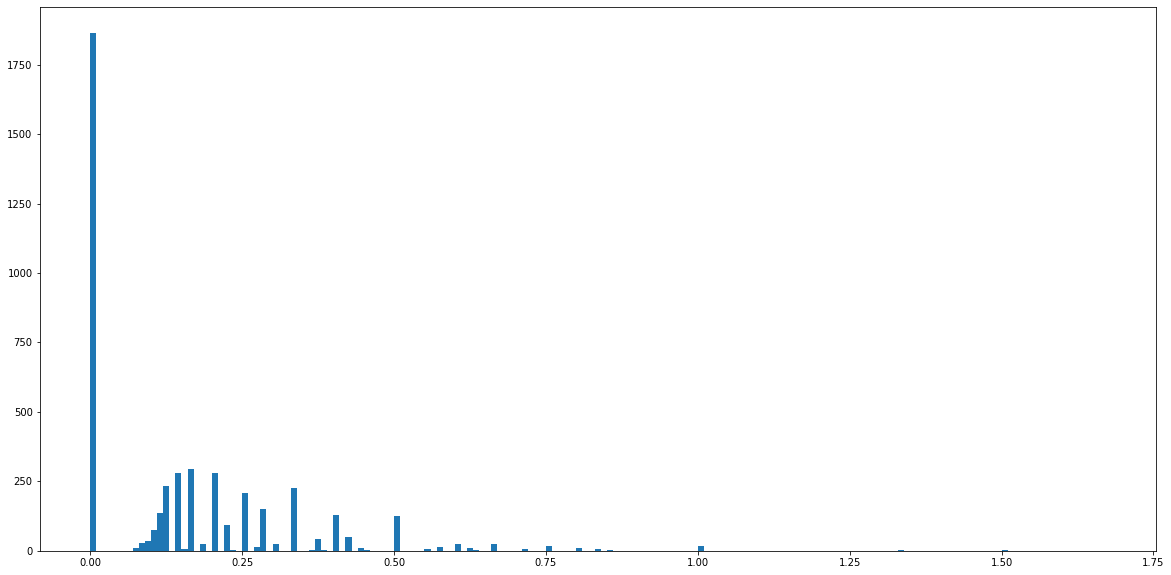

In [155]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.hist(model_edit_dist, bins=np.arange(min(model_edit_dist), max(model_edit_dist)+0.01, step=0.01))

(array([1.578e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.300e+01, 2.000e+01, 3.900e+01, 8.300e+01, 1.370e+02,
        2.180e+02, 1.000e+00, 2.650e+02, 1.200e+01, 3.430e+02, 0.000e+00,
        3.300e+01, 0.000e+00, 3.050e+02, 1.000e+00, 1.010e+02, 3.000e+00,
        0.000e+00, 2.630e+02, 1.000e+00, 9.000e+00, 1.610e+02, 0.000e+00,
        3.100e+01, 0.000e+00, 0.000e+00, 2.560e+02, 0.000e+00, 0.000e+00,
        8.000e+00, 5.300e+01, 0.000e+00, 0.000e+00, 1.460e+02, 2.000e+00,
        7.400e+01, 0.000e+00, 9.000e+00, 3.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.480e+02, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 4.000e+00, 0.000e+00, 2.300e+01, 1.000e+00, 0.000e+00,
        4.300e+01, 0.000e+00, 4.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.900e+01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 6.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+01, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 3.000e+0

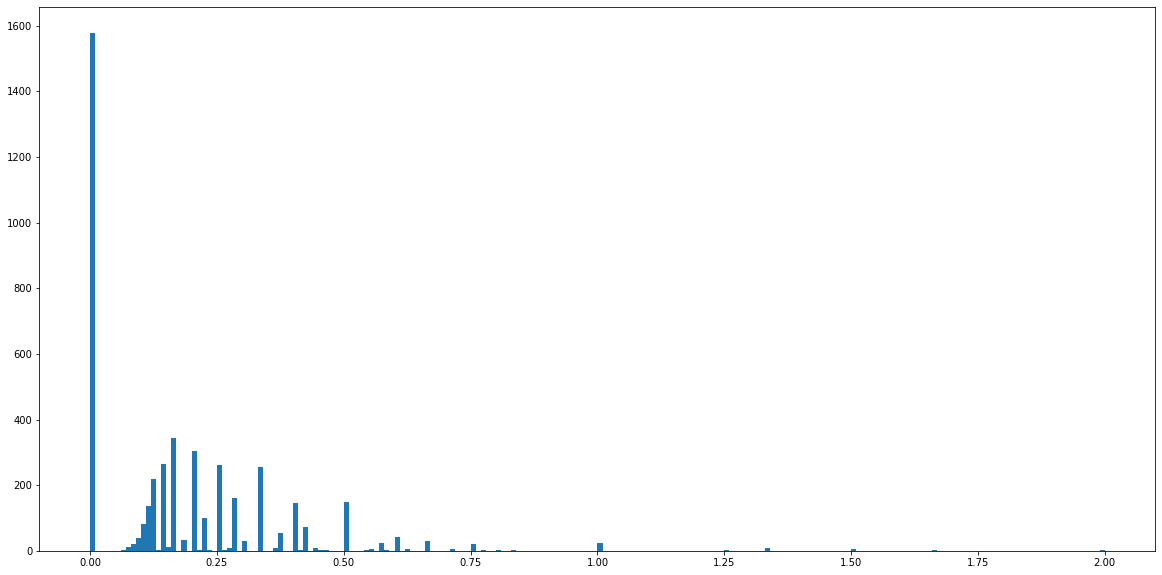

In [156]:
plt.figure(figsize=(20,10))
plt.hist(indic_edit_dist, bins=np.arange(min(indic_edit_dist), max(indic_edit_dist)+0.01, step=0.01))

In [158]:
dakshina_test_df[dakshina_test_df['indic_edit_distance'] >= 0.9]

,hindi,english,freq,model_predicted,indictrans_predicted,model_edit_distance,indic_edit_distance
254,आइसीसी,icc,3,icc,isisi,0.000000,1.333333
256,आईपीसी,ipc,3,ipc,ipisi,0.000000,1.000000
312,आरओ,ro,3,aro,aaro,0.500000,1.000000
313,आरपी,rp,3,arp,arapy,0.500000,1.500000
422,ईए,ea,2,ea,ie,0.000000,1.000000
538,एएसआई,asi,3,asai,eesai,0.333333,1.000000
542,एक्सएम,xm,3,exme,exem,1.000000,1.000000
545,एजे,aj,3,eje,age,1.000000,1.000000
547,एडीपी,adp,3,edipi,edipi,1.000000,1.000000
556,एफटीआईआई,ftii,3,fti,apatiai,0.250000,1.000000


In [159]:
dakshina_test_df[dakshina_test_df['model_edit_distance'] == 0.0]

,hindi,english,freq,model_predicted,indictrans_predicted,model_edit_distance,indic_edit_distance
0,अंक,ank,5,ank,ank,0.0,0.000000
2,अंकित,ankit,3,ankit,ankit,0.0,0.000000
5,अंकों,ankon,2,ankon,ankon,0.0,0.000000
7,अंकोर,ankor,2,ankor,ankor,0.0,0.000000
9,अंगारक,angarak,2,angarak,angarak,0.0,0.000000
...,...,...,...,...,...,...,...
4487,हैतो,haito,3,haito,haito,0.0,0.000000
4493,हॉन्ग,hong,3,hong,hong,0.0,0.000000
4497,होल्डिंग,holding,3,holding,holding,0.0,0.000000
4499,होशंगाबाद,hoshangabad,2,hoshangabad,hoshangabad,0.0,0.000000


In [160]:
dakshina_test_df[dakshina_test_df['indic_edit_distance'] == 0.0]

,hindi,english,freq,model_predicted,indictrans_predicted,model_edit_distance,indic_edit_distance
0,अंक,ank,5,ank,ank,0.000000,0.0
2,अंकित,ankit,3,ankit,ankit,0.000000,0.0
5,अंकों,ankon,2,ankon,ankon,0.000000,0.0
7,अंकोर,ankor,2,ankor,ankor,0.000000,0.0
9,अंगारक,angarak,2,angarak,angarak,0.000000,0.0
...,...,...,...,...,...,...,...
4493,हॉन्ग,hong,3,hong,hong,0.000000,0.0
4496,होऊंगा,hounga,3,hoounga,hounga,0.166667,0.0
4497,होल्डिंग,holding,3,holding,holding,0.000000,0.0
4499,होशंगाबाद,hoshangabad,2,hoshangabad,hoshangabad,0.000000,0.0


In [161]:
dakshina_test_df[dakshina_test_df['model_edit_distance'] == dakshina_test_df['indic_edit_distance']]

,hindi,english,freq,model_predicted,indictrans_predicted,model_edit_distance,indic_edit_distance
0,अंक,ank,5,ank,ank,0.000000,0.000000
1,अंक,anka,1,ank,ank,0.250000,0.250000
2,अंकित,ankit,3,ankit,ankit,0.000000,0.000000
3,अंकों,anakon,1,ankon,ankon,0.166667,0.166667
4,अंकों,ankhon,1,ankon,ankon,0.166667,0.166667
...,...,...,...,...,...,...,...
4494,हॉफ,half,2,hoff,hof,0.500000,0.500000
4495,हॉफ,hoaf,1,hoff,hof,0.250000,0.250000
4497,होल्डिंग,holding,3,holding,holding,0.000000,0.000000
4498,होशंगाबाद,hoshangabaad,1,hoshangabad,hoshangabad,0.083333,0.083333


In [ ]:
t1 = tf.sparse.from_dense(tf.expand_dims(tf.strings.bytes_split('xyz'), axis=0))
t2 = tf.sparse.from_dense(tf.expand_dims(tf.strings.bytes_split('xy'), axis=0))

distance = tf.edit_distance(t1, t2, normalize=True)
distance[0].numpy()

0.5

In [ ]:
t1 = tf.sparse.from_dense(tf.expand_dims(tf.strings.bytes_split('xyz'), axis=0))
t2 = tf.sparse.from_dense(tf.expand_dims(tf.strings.bytes_split(''), axis=0))

distance = tf.edit_distance(t1, t2, normalize=True)
distance[0].numpy()

inf

In [ ]:
t1 = tf.sparse.from_dense(tf.expand_dims(tf.strings.bytes_split('yz'), axis=0))
t2 = tf.sparse.from_dense(tf.expand_dims(tf.strings.bytes_split('xyz'), axis=0))

distance = tf.edit_distance(t1, t2, normalize=True)
distance[0].numpy()

0.33333334

In [ ]:
t1 = tf.sparse.from_dense(tf.expand_dims(tf.strings.bytes_split('xyz'), axis=0))
t2 = tf.sparse.from_dense(tf.expand_dims(tf.strings.bytes_split('yz'), axis=0))

distance = tf.edit_distance(t1, t2, normalize=True)
distance[0].numpy()

0.5

In [162]:
dakshina_test_df = pd.read_csv('dakshina_acc_results.csv')

In [163]:
dakshina_test_df.head()

,hindi,english,freq,model_predicted,indictrans_predicted,model_edit_distance,indic_edit_distance
0,अंक,ank,5,ank,ank,0.000000,0.000000
1,अंक,anka,1,ank,ank,0.250000,0.250000
2,अंकित,ankit,3,ankit,ankit,0.000000,0.000000
3,अंकों,anakon,1,ankon,ankon,0.166667,0.166667
4,अंकों,ankhon,1,ankon,ankon,0.166667,0.166667


In [164]:
model_edit_dedup = dakshina_test_df.groupby(['hindi'])['model_edit_distance'].min().reset_index()
indic_edit_dedup = dakshina_test_df.groupby(['hindi'])['indic_edit_distance'].min().reset_index()

In [165]:
dakshina_test_df.groupby(['hindi'])['model_edit_distance'].min()

hindi
अंक          0.000000
अंकित        0.000000
अंकों        0.000000
अंकोर        0.000000
अंगारक       0.000000
               ...   
हॉफ          0.250000
होऊंगा       0.166667
होल्डिंग     0.000000
होशंगाबाद    0.000000
होस्टेस      0.000000
Name: model_edit_distance, Length: 2500, dtype: float64

In [166]:
model_acc_percent = len(model_edit_dedup[model_edit_dedup['model_edit_distance'] == 0])/len(model_edit_dedup)
indic_acc_percent = len(indic_edit_dedup[indic_edit_dedup['indic_edit_distance'] == 0])/len(indic_edit_dedup)
print(f"Out of {len(model_edit_dedup)}, model predicted {model_acc_percent * 100}% correctly")
print(f"Out of {len(indic_edit_dedup)}, indic predicted {indic_acc_percent * 100}% correctly")

Out of 2500, model predicted 74.56% correctly
Out of 2500, indic predicted 63.12% correctly
